In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso,Ridge,ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,roc_curve,roc_auc_score,mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier

# Read the CSV file into a DataFrame: df
df = pd.read_csv('gapminder.csv')

pd.set_option('display.max_rows', 500)

# Create arrays for features and target variable
y = df.life
X = df.fertility

#print(y)
#print(X)

# Print the dimensions of X and y before reshaping
print("y before reshaping: {}".format(y.shape))
print("X before reshaping: {}".format(X.shape))

# Reshape X and y
y = y.reshape(-1,1)
X = X.reshape(-1,1)

# Print the dimensions of X and y after reshaping
print("y after reshaping: {}".format(y.shape))
print("X after reshaping: {}".format(X.shape))

#print(y)
#print(X)

y before reshaping: (139,)
X before reshaping: (139,)
y after reshaping: (139, 1)
X after reshaping: (139, 1)


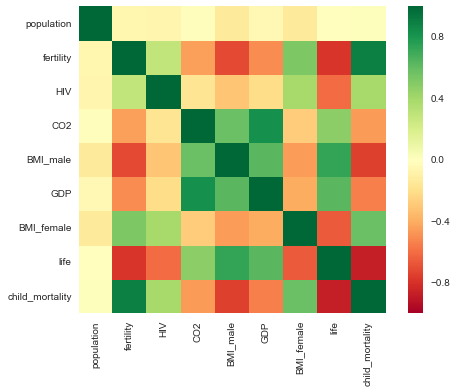

In [4]:
# life and fertility are negatively correlated while GDP and life are positively correlated

sns.heatmap(df.corr(), square=True, cmap='RdYlGn')
plt.show()

0.619244216774


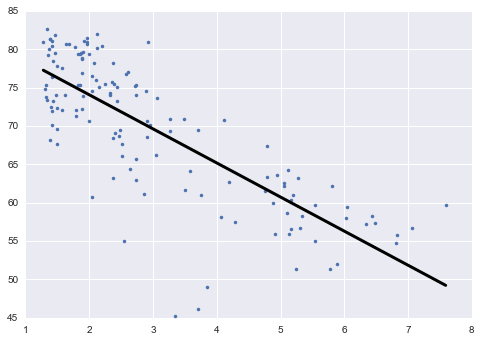

In [5]:
X_fertility = df.fertility.reshape(-1,1)

# Create the regressor: reg
reg = LinearRegression()

# Create the prediction space
prediction_space = np.linspace(min(X_fertility), max(X_fertility)).reshape(-1,1)

# Fit the model to the data
reg.fit(X_fertility, y)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

# Print R^2 
print(reg.score(X_fertility, y))

# Plot regression line
plt.plot(df.fertility, df.life, marker='.', linestyle = 'none')
plt.plot(prediction_space, y_pred, color='black', linewidth=3)
plt.show()

In [6]:
X = df.drop('life', axis=1).values
#print(X)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R-squared: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R-squared: 0.8380575197176654
Root Mean Squared Error: 3.2474943318800253


In [7]:
# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X,y,cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[ 0.81720801  0.8291746   0.9020908   0.80633892  0.9449591 ]
Average 5-Fold CV Score: 0.8599542846593934


In [8]:
# Perform 3-fold CV
cvscores_3 = cross_val_score(reg, X, y, cv = 3)
print('CV 3folds: ',np.mean(cvscores_3))

# Perform 10-fold CV
cvscores_10 = cross_val_score(reg, X, y, cv = 10)
print('CV 10folds:',np.mean(cvscores_10))

CV 3folds:  0.871873731179
CV 10folds: 0.843596946712


In [9]:
df_columns = df.drop('life',axis=1).columns
#df_columns = np.array(df.drop('life',axis=1).columns.values.tolist())
#df_columns.drop('life',axis=1)
print(df_columns)

Index(['population', 'fertility', 'HIV', 'CO2', 'BMI_male', 'GDP',
       'BMI_female', 'child_mortality'],
      dtype='object')


[-0.         -0.         -0.          0.          0.          0.         -0.
 -0.07087587]


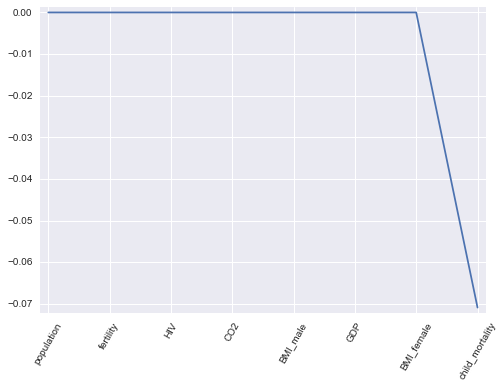

In [10]:
#print(X)

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X,y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.plot(range(len(df_columns)), lasso_coef)
plt.xticks(range(len(df_columns)), df_columns.values, rotation=60)
plt.margins(0.02)
plt.show()

In [11]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

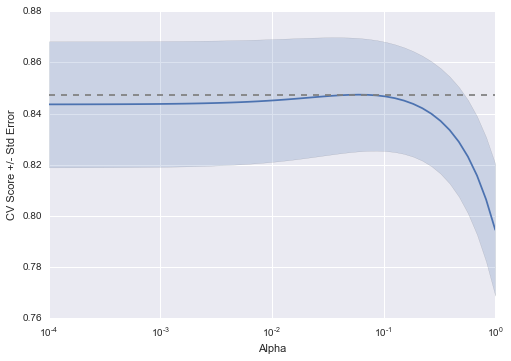

In [12]:
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge,X,y,cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)

In [13]:
#fine-tuning
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,random_state=42)

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net,param_grid,cv=5)

# Fit it to the training data
gm_cv.fit(X_train,y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

C:\Users\Ashadev\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\Ashadev\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ashadev\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\Ashadev\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Ashadev\Anaconda3\lib\site-

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.20689655172413793}
Tuned ElasticNet R squared: 0.8668454275265797
Tuned ElasticNet MSE: 10.056789512482279
